# Lab 2: Portfolio Optimization

In this lab we will explore:
- How to compute the return of a portfolio of assets.
- How to compute the volatility of a portfolio of assets.
- How to optimize a portfolio.

## Imports

In this lab we use the following new packages:
- `cvxpy`: Used for convex optimization and quadratic programming.
- `numpy`: Useful for matrix opperations.
- `matplotlib`: Plotting library.
- `seaborn`: A wrapper for `matplotlib` that makes charting a little easier.

In [1]:
import sf_quant.data as sfd
import sf_quant.optimizer as sfo
import polars as pl
import datetime as dt
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Data

Here we pull daily returns for Apple, Ford, Verizon, and Coke.

In [2]:
start = dt.date(2024, 1, 1)
end = dt.date(2024, 12, 31)

in_sample = [start, dt.date(2024, 5, 31)]
out_of_sample = [dt.date(2024, 6, 1), end]

columns = [
    'date',
    'barrid',
    'ticker',
    'return'
]

tickers = sorted(['AAPL', 'F', 'VZ', 'K'])

returns = (
        sfd.load_assets(
        start=start,
        end=end,
        in_universe=True,
        columns=columns
    )
    .filter(
        pl.col('ticker').is_in(tickers)
    )
    .with_columns(
        pl.col('return').truediv(100)
    )
)

returns

date,barrid,ticker,return
date,str,str,f64
2024-01-02,"""USAB1X1""","""AAPL""",-0.035787
2024-01-03,"""USAB1X1""","""AAPL""",-0.007488
2024-01-04,"""USAB1X1""","""AAPL""",-0.0127
2024-01-05,"""USAB1X1""","""AAPL""",-0.004013
2024-01-08,"""USAB1X1""","""AAPL""",0.024175
…,…,…,…
2024-12-24,"""USAHQN1""","""K""",0.001487
2024-12-26,"""USAHQN1""","""K""",0.003588
2024-12-27,"""USAHQN1""","""K""",0.00074


## Expected Returns Forecast

In practice we will forecast returns using a combination of signal forecasts, but for demonstration purposes we will just use the average historical returns as our expected returns forecast.

### Instructions
1. Create a expected returns vector for the `in_sample` period (it should be 1x4)

In [ ]:
def expected_returns_task(returns: pl.DataFrame) -> np.array:
    """
    Compute the average daily return of each asset for the in_sample period.

    Args:
        returns (pl.DataFrame): a data frame containing date, ticker, and return columns

    Returns:
        np.array: a numpy array (1x4) with an entry for the average return of each ticker (sorted alphabetically by ticker)
    """

    return returns.group_by('ticker').agg(pl.col('return').mean())['return']
    pass

er_vector = expected_returns_task(returns)

er_vector

return
f64
-0.000293
0.001164
0.00058
0.001722


## Covariance Matrix Forecast

In practice we will use forecasted covariance matrices from Barra, but for demonstration purposes we will use the historical covariance matrix as our forecast.

### Instructions

1. Create the covariance matrix using returns from the `in_sample` period.

In [4]:
def covariance_matrix_task(returns: pl.DataFrame) -> np.array:
    """
    Compute the historical covariance matrix using the returns from the in_sample period.

    Args:
        returns (pl.DataFrame): a data frame containing date, ticker, and return columns

    Returns:
        np.array: a numpy array (4x4) containing the covariances of the assets (columns and rows are sorted alphabetically by ticker)
    """
    returns_names = returns.pivot( # pivots the dataframe on time
        values='return',
        columns = 'ticker',
        index='date')
    returns_names = returns_names.select(sorted(returns_names.columns)) # sorts the columns in alphabetical order
    return np.cov(returns_names.select(pl.exclude('date')), rowvar=False) # returns the covariance matrix
                  
    pass

cov_mat = covariance_matrix_task(returns)

cov_mat

/tmp/ipykernel_3107057/1455079576.py:11: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  returns_names = returns.pivot( # pivots the dataframe on time


array([[ 2.04127103e-04,  3.55567228e-05, -4.02288860e-05,
        -1.17666119e-05],
       [ 3.55567228e-05,  5.14309955e-04,  1.61279563e-05,
         2.97351791e-05],
       [-4.02288860e-05,  1.61279563e-05,  2.50588424e-04,
         1.45350064e-05],
       [-1.17666119e-05,  2.97351791e-05,  1.45350064e-05,
         1.78333936e-04]])

## Mean Variance Optimization

In order to determine how much of our portfolio to invest in each assset, we will use mean variance optimization to determine the maximum sharpe ratio portfolio.

### Instructions
1. Create the objective function for the `cp.Problem`

utility = portfolio_return - 0.5 * gamma * portfolio_variance

2. Constrain the problem such that
- Weights sum to 1 (full investment)
- Weights are greater than 0 (long only)
- Weights are less than 1 (no buying on margin)

3. Find the optimal portfolio weights by solving the `cp.Problem`

In [16]:
def optimization_task(tickers: list[str], er_vector: np.array, cov_mat: np.array, gamma=50) -> pl.DataFrame:
    """
    Compute the optimal weights of the portfolio given the expected returns forecast and the covariance matrix forecast.

    Args:
        ticker (list[str]): a list of tickers sorted alphabetically
        er_vector (np.array): a numpy array (1x4) with an entry for the average return of each ticker (sorted alphabetically by ticker)
        cov_mat (np.array): a numpy array (4x4) containing the covariances of the assets (columns and rows are sorted alphabetically by ticker)

    Returns:
        pl.DataFrame: a data frame with columns ticker and weight
    """
    def utility(w):
        return w @ er_vector - (.5 * gamma * (w.T@cov_mat@w))
    w = cp.Variable(4)
    constraints = [cp.sum(w) == 1, w >= 0, w <=1]
    objective = cp.Maximize(utility(w))
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return pl.DataFrame({'ticker': tickers, 'weight': w.value})
    pass

weights = optimization_task(tickers, er_vector, cov_mat)

weights

ticker,weight
str,f64
"""AAPL""",0.249701
"""F""",0.083686
"""K""",0.236565
"""VZ""",0.430048


## In Sample vs. Out of Sample Performance

Now that we've identified the optimal weights let's see if our optimized portfolio outperforms a simple equal weighted portfolio.

### Instructions
1. Compute the baseline returns for the `out_of_sample` period by computing the equal weight returns for each period.
2. Compute the optimized returns for the `out_of_sample` period by computing the weighted return of the portfolio for each period using our optimal weights.
3. Plot the cumulative returns of each strategy in one chart.
4. Compute the total return, average daily return (annualized), volatility (annualized), and sharpe ratio (annualized) for both strategies.
5. Go back and try a handful of different `gamma` values in your optimizer and see how your performance results change.
6. Write a few sentences commenting on the results.

In [18]:
def baseline_returns_task(returns: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the average daily return of each asset for the out_of_sample period.

    Args:
        returns (pl.DataFrame): a data frame containing date, ticker, and return columns

    Returns:
        pl.DataFrame: a data frame containing date, return, and cumulative_return columns
    """
    returns = returns.group_by('date').agg(pl.col('return').mean()).sort('date')
    returns = returns.with_columns(
        ((1 + pl.col('return')).cum_prod() - 1).alias('cum_returns')
    )
    return returns
    pass

baseline_returns = baseline_returns_task(returns)

baseline_returns

date,return,cum_returns
date,f64,f64
2024-01-02,0.006535,0.006535
2024-01-03,-0.010535,-0.004069
2024-01-04,-0.005258,-0.009306
2024-01-05,0.007114,-0.002258
2024-01-08,0.007424,0.00515
…,…,…
2024-12-24,0.005395,0.220322
2024-12-26,0.0039435,0.225134
2024-12-27,-0.004369,0.219782


In [7]:
def optimized_returns_task(returns: pl.DataFrame, weights: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the average daily return of each asset for the out_of_sample period.

    Args:
        returns (pl.DataFrame): a data frame containing date, ticker, and return columns
        weights (pl.DataFrame): a data frame with columns ticker and weight

    Returns:
        pl.DataFrame: a data frame containing date, return, and cumulative_return columns
    """
    weights = weights['weight']
    
    w_returns = returns.with_columns(
        pl.when(pl.col('ticker') == "AAPL")
        .then(pl.col('return') * weights[0])
        .when(pl.col('ticker') == "F")
        .then(pl.col('return') * weights[1])
        .when(pl.col('ticker') == "K")
        .then(pl.col('return') * weights[2])
        .when(pl.col('ticker') == "VZ")
        .then(pl.col('return') * weights[3])
        )

    returns = w_returns.group_by('date').agg(pl.col('return').sum()).sort('date')
    returns = returns.with_columns(
        ((1 + pl.col('return')).cum_prod() - 1).alias('cum_returns')
    )
    return returns
    pass

optimized_returns = optimized_returns_task(returns, weights)

optimized_returns

date,return,cum_returns
date,f64,f64
2024-01-02,0.0313,0.0313
2024-01-03,0.007202,0.038727
2024-01-04,0.005363,0.044298
2024-01-05,0.021082,0.066314
2024-01-08,-0.002488,0.063661
…,…,…
2024-12-24,-0.003505,0.12632
2024-12-26,0.00402,0.130847
2024-12-27,-0.001001,0.129715


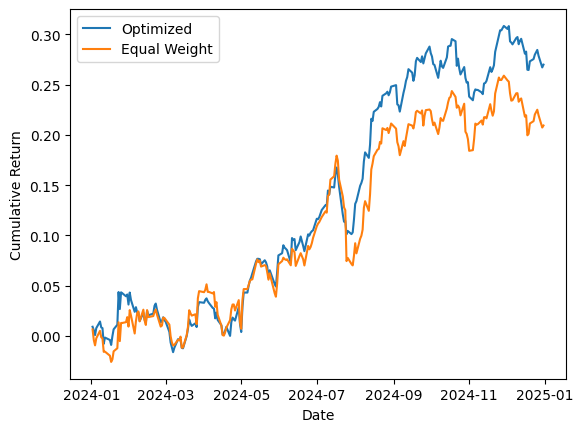

In [19]:
plt.plot(optimized_returns['date'], optimized_returns['cum_returns'], label='Optimized')
plt.plot(optimized_returns['date'], baseline_returns['cum_returns'], label='Equal Weight')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

In [21]:
# TODO: Compute the total_return, average_return, volatility, and sharpe for the baseline and optimized strategies
b_total_return =  baseline_returns['cum_returns'][-1]
o_total_return =  optimized_returns['cum_returns'][-1]
b_avg_return = baseline_returns['return'].mean()
o_avg_return =  optimized_returns['return'].mean()
b_vol = baseline_returns['return'].std()
o_vol = optimized_returns['return'].std()
b_sharpe = np.sqrt(255) * b_avg_return / b_vol
o_sharpe = np.sqrt(255) * o_avg_return / o_vol
print(f"The total return for the baseline was {b_total_return}, while for the optimized strategy it was {o_total_return}.\nThe average return for the baseline was {b_avg_return}, while for the optimized strategy it was {o_avg_return}.\nThe volatility for the baseline was {b_vol}, while for the optimized strategy it was {o_vol}.\nThe sharpe ratio for the baseline was {b_sharpe}, while for the optimized strategy it was {o_sharpe}.")


The total return for the baseline was 0.2094311283657373, while for the optimized strategy it was 0.27000279409336514.
The average return for the baseline was 0.0007933591269841268, while for the optimized strategy it was 0.000978714651665379.
The volatility for the baseline was 0.008786631007057217, while for the optimized strategy it was 0.007741247268081221.
The sharpe ratio for the baseline was 1.4418415078600195, while for the optimized strategy it was 2.0189020097243007.


With Gamma=1.0
The total return for the baseline was 0.2094311283657373, while for the optimized strategy it was 0.13169579939827636.
The average return for the baseline was 0.0007933591269841268, while for the optimized strategy it was 0.0005800515873015873.
The volatility for the baseline was 0.008786631007057217, while for the optimized strategy it was 0.013354172979613515.
The sharpe ratio for the baseline was 1.4418415078600195, while for the optimized strategy it was 0.6936169736931365.
With Gamma=2.51188643150958
The total return for the baseline was 0.2094311283657373, while for the optimized strategy it was 0.13169579871306425.
The average return for the baseline was 0.0007933591269841268, while for the optimized strategy it was 0.0005800515849920798.
The volatility for the baseline was 0.008786631007057217, while for the optimized strategy it was 0.013354172987736465.
The sharpe ratio for the baseline was 1.4418415078600195, while for the optimized strategy it was 0.693616970

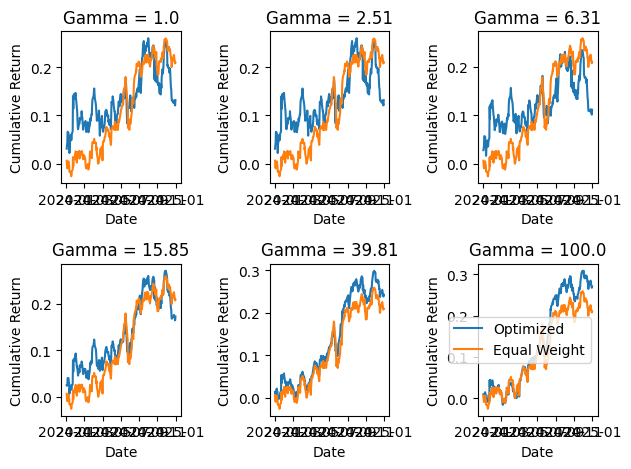

In [22]:
val = np.power(100, 1/5)
for i in range(6):
    gamma = (val ** i)
    def optimization_task(tickers: list[str], er_vector: np.array, cov_mat: np.array, gamma=gamma) -> pl.DataFrame:
        """
        Compute the optimal weights of the portfolio given the expected returns forecast and the covariance matrix forecast.

        Args:
            ticker (list[str]): a list of tickers sorted alphabetically
            er_vector (np.array): a numpy array (1x4) with an entry for the average return of each ticker (sorted alphabetically by ticker)
            cov_mat (np.array): a numpy array (4x4) containing the covariances of the assets (columns and rows are sorted alphabetically by ticker)

        Returns:
            pl.DataFrame: a data frame with columns ticker and weight
        """
        def utility(w):
            return w @ er_vector - (.5 * gamma * (w.T@cov_mat@w))
        w = cp.Variable(4)
        constraints = [cp.sum(w) == 1, w >= 0, w <=1]
        objective = cp.Maximize(utility(w))
        prob = cp.Problem(objective, constraints)
        prob.solve()
        return pl.DataFrame({'ticker': tickers, 'weight': w.value})
        pass

    weights = optimization_task(tickers, er_vector, cov_mat)
    
    def optimized_returns_task(returns: pl.DataFrame, weights: pl.DataFrame) -> pl.DataFrame:
        """
        Compute the average daily return of each asset for the out_of_sample period.

        Args:
            returns (pl.DataFrame): a data frame containing date, ticker, and return columns
            weights (pl.DataFrame): a data frame with columns ticker and weight

        Returns:
            pl.DataFrame: a data frame containing date, return, and cumulative_return columns
        """
        weights = weights['weight']
        
        w_returns = returns.with_columns(
            pl.when(pl.col('ticker') == "AAPL")
            .then(pl.col('return') * weights[0])
            .when(pl.col('ticker') == "F")
            .then(pl.col('return') * weights[1])
            .when(pl.col('ticker') == "K")
            .then(pl.col('return') * weights[2])
            .when(pl.col('ticker') == "VZ")
            .then(pl.col('return') * weights[3])
            )

        returns = w_returns.group_by('date').agg(pl.col('return').sum()).sort('date')
        returns = returns.with_columns(
            ((1 + pl.col('return')).cum_prod() - 1).alias('cum_returns')
        )
        return returns
    optimized_returns = optimized_returns_task(returns, weights)
    subp = 231 + i
    plt.subplot(subp)
    plt.plot(optimized_returns['date'], optimized_returns['cum_returns'], label='Optimized')
    plt.plot(optimized_returns['date'], baseline_returns['cum_returns'], label='Equal Weight')

    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title(f"Gamma = {round(gamma, 2)}")
    b_total_return =  baseline_returns['cum_returns'][-1]
    print(f"With Gamma={gamma}")
    o_total_return =  optimized_returns['cum_returns'][-1]
    b_avg_return = baseline_returns['return'].mean()
    o_avg_return =  optimized_returns['return'].mean()
    b_vol = baseline_returns['return'].std()
    o_vol = optimized_returns['return'].std()
    b_sharpe = np.sqrt(255) * b_avg_return / b_vol
    o_sharpe = np.sqrt(255) * o_avg_return / o_vol
    print(f"The total return for the baseline was {b_total_return}, while for the optimized strategy it was {o_total_return}.\nThe average return for the baseline was {b_avg_return}, while for the optimized strategy it was {o_avg_return}.\nThe volatility for the baseline was {b_vol}, while for the optimized strategy it was {o_vol}.\nThe sharpe ratio for the baseline was {b_sharpe}, while for the optimized strategy it was {o_sharpe}.")
plt.legend()
plt.tight_layout()
plt.show()

Comment here on the results that you have found.

The higher the gamma, the higher the sharpe ratio. This is a relatively small sample, and I believe that it's impacted by the fact that the worst performing and most volataile stock was the one that had the highest expected return, so when it tanked, the more volatile strategies had both very low average returns and high volatilites. This doesn't necessarily mean that a super high gamma is always the best strategy (if we had gotten a positive anamoly instead of a negative oen the results might have been different), but the best strategy here was risk averse.

## `sf-quant` Optimizer Module

What if I told you that you don't have to write out the optimization code by hand again? Wouldn't that be great? Lucky for you we've pre-built a module in the `sf-quant` package that provides abstracted functionality for portfolio optimization.

### Instructions

- Create a `list` of constraints including `FullInvestment`, `LongOnly`, and `NoBuyingOnMargin`.
- Get the weights from the `sf_quant.optimizer.mve_optimizer` function using your previously computed returns forecast and covariance matrix.

Note: you should get really similar weights to your previous results.

In [23]:
def task_sf_optimizer_weights(tickers: list[str], er_vector: np.ndarray, cov_mat: np.ndarray) -> pl.DataFrame:
    """
    Compute the optimal weights of the portfolio given the expected returns forecast and the covariance matrix forecast.
    Make sure to use the sf_quant package.

    Args:
        ticker (list[str]): a list of tickers sorted alphabetically
        er_vector (np.array): a numpy array (1x4) with an entry for the average return of each ticker (sorted alphabetically by ticker)
        cov_mat (np.array): a numpy array (4x4) containing the covariances of the assets (columns and rows are sorted alphabetically by ticker)

    Returns:
        pl.DataFrame: a data frame with columns ticker and weight
    """
    
    constraints = [sfo.FullInvestment(), sfo.LongOnly(), sfo.NoBuyingOnMargin()]
    weights = sfo.mve_optimizer(tickers, er_vector, constraints=constraints, covariance_matrix=cov_mat)
    return weights
    pass

weights_sf = task_sf_optimizer_weights(tickers, er_vector, cov_mat)

weights_sf

barrid,weight
str,f64
"""AAPL""",1.7394e-22
"""F""",1.8445e-22
"""K""",1.4065e-23
"""VZ""",1.0


## Barra Covariance Matrix

Now let's improve our portfolio by using a better forecast for the covariance matrix. We are very fortunate to have access to the MSCI Barra covariance matrix forecasts. In this task you will load the Barra covariance matrix for the last day of your in sample period and compute the new optimal weights.

### Instructions

- Use the `sf_quant.data.construct_covariance_matrix` function to pull the covariance matrix for the last market date of the in sample period.
- Compute the optimal weights of your portfolio using this new covariance matrix.
- Hint: since the Barra covariance matrix is annualized, you will need to multiply your returns forecast by 252.

In [24]:
def task_barra_optimizer_weights(returns: pl.DataFrame) -> pl.DataFrame:
    """ 
    Compute the optimal weights of the portfolio given the expected returns forecast and the barra covariance matrix forecast.
    Make sure to use the sf_quant package.

    Args:
        returns (pl.DataFrame): a data frame containing date, ticker, and return columns

    Returns:
        pl.DataFrame: a data frame with columns barrid and weight
    """
    return sfd.construct_covariance_matrix(dt.date(2024, 12, 31), ["USAB1X1", "USAFK41", "USAHQN1", "USABND1"])
    pass



cov_barra = task_barra_optimizer_weights(returns)

weights_barra = task_sf_optimizer_weights(tickers, er_vector, cov_barra.to_numpy()[:, 1:])

weights_barra

barrid,weight
str,f64
"""AAPL""",0.313105
"""F""",0.143773
"""K""",0.088249
"""VZ""",0.454873


## Performance Analysis

Now that we've got the Barra optimal weights, let's see how they perform compared to our out of sample baseline.

### Instructions
1. Compute the optimized barra returns for the `out_of_sample` period by computing the weighted return of the portfolio for each period using our optimal weights.
2. Plot the cumulative returns of each strategy in one chart.
3. Compute the total return, average daily return (annualized), volatility (annualized), and sharpe ratio (annualized) for both strategies.
4. Go back and try a handful of different `gamma` values in your optimizer and see how your performance results change.
5. Write a few sentences commenting on the results.

In [26]:
def optimized_barra_returns_task(returns: pl.DataFrame, weights_barra: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the average daily return of each asset for the out_of_sample period.

    Args:
        returns (pl.DataFrame): a data frame containing date, ticker, and return columns
        weights_barra (pl.DataFrame): a data frame with columns ticker and weight

    Returns:
        pl.DataFrame: a data frame containing date, return, and cumulative_return columns
    """
    # TODO: Finish function
    pass

optimized_returns_barra = optimized_barra_returns_task(returns, weights_barra)

optimized_returns_barra

In [14]:
# TODO: Chart the baseline and optimized cumulative returns

In [15]:
# TODO: Compute the total_return, average_return, volatility, and sharpe for the baseline and optimized strategies

Comment here on the results that you have found.